### Section A

In [28]:
import os
import geopandas as gpd
import numpy as np
import pandas as pd
import descartes
import geopy
from geopy.geocoders import Nominatim,GoogleV3,ArcGIS,OpenMapQuest,Yandex
from geopy.extra.rate_limiter import RateLimiter
from fiona.crs import from_epsg
from shapely.geometry import LineString, Point, Polygon
from shapely.ops import transform
from geopandas.tools import reverse_geocode
import geopandas as gpd
from geopandas.tools.geocoding import geocode
import matplotlib.pyplot as plt
import tqdm

Task 1- reading data from csv file

In [3]:
file_path = r'data\travelTimes_2015_Helsinki.csv'
col_list = ["from_x", "from_y", "to_x", "to_y"]
data = pd.read_csv(file_path, usecols=col_list)
data.head()


,from_x,from_y,to_x,to_y
0,24.970438,60.311917,24.856034,60.399941
1,24.970438,60.311917,24.860568,60.400014
2,24.970438,60.311917,24.865102,60.400086
3,24.970438,60.311917,24.869636,60.400159
4,24.970438,60.311917,24.842582,60.397478


Task 2- create lists




In [4]:
orig_points = []
dest_points = []


Task 3- populate lists with Shapely Points




In [5]:
for index, row in data.iterrows() :
    orig_points.append(Point(row['from_x'], row['from_y']))
    dest_points.append(Point(row['to_x'], row['to_y']))
print(orig_points[1].x)
print(orig_points[1].y)

24.9704379
60.3119173


Task 4- create Shapely line objects and printing average length


In [6]:
lines = []

for i in range(len(orig_points)) :
    lines.append(LineString([orig_points[i], dest_points[i]]))

avg_line = sum([line.length for line in lines]) / len(lines)
print('average length is: ',avg_line)

average length is:  0.21502224823227184


### Section B
#### part 1:

reading data from csv file using Pandas


In [104]:
file_path = r'data\some_posts.csv'
df = pd.read_csv(file_path)
df['timestamp'] =pd.to_datetime(df.timestamp, errors= 'coerce')
print(df.dtypes)
df.head()

lat                 float64
lon                 float64
timestamp    datetime64[ns]
userid                int64
dtype: object


,lat,lon,timestamp,userid
0,-24.980792,31.484633,2015-07-07 03:02:00,66487960
1,-25.499225,31.508906,2015-07-07 03:18:00,65281761
2,-24.342578,30.930866,2015-03-07 03:38:00,90916112
3,-24.854614,31.519718,2015-10-07 05:04:00,37959089
4,-24.921069,31.520836,2015-10-07 05:19:00,27793716


creating points from the data and insert to dataframe as geometry column

In [105]:

geometry = gpd.points_from_xy(df.lon,df.lat)
df['geometry'] = geometry

print(df.shape)
df.head()


(81379, 5)


,lat,lon,timestamp,userid,geometry
0,-24.980792,31.484633,2015-07-07 03:02:00,66487960,POINT (31.484633302 -24.980792492)
1,-25.499225,31.508906,2015-07-07 03:18:00,65281761,POINT (31.508905612 -25.499224667)
2,-24.342578,30.930866,2015-03-07 03:38:00,90916112,POINT (30.930866066 -24.342578456)
3,-24.854614,31.519718,2015-10-07 05:04:00,37959089,POINT (31.519718439 -24.85461393)
4,-24.921069,31.520836,2015-10-07 05:19:00,27793716,POINT (31.520835558 -24.921068894)


Convert DataFrame into a GeoDataFrame with WGS84 coordinate system

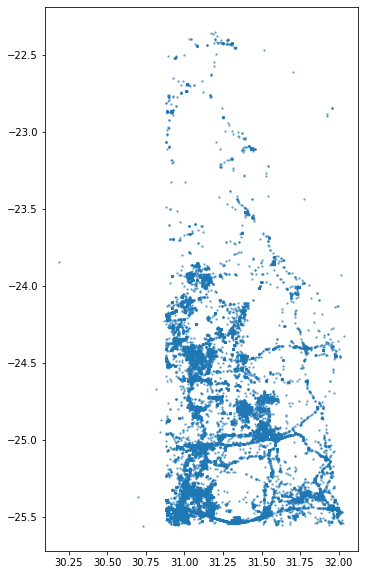

In [123]:
# crate geodataframe
Kruger_posts_gdf = gpd.GeoDataFrame(df, geometry='geometry', crs={'init': 'epsg:4326'})
Kruger_posts_gdf.crs

# plot
ax = Kruger_posts_gdf.plot(figsize=(10, 10), alpha=0.5, markersize=2)
plt.savefig('Kruger_posts.png')
plt.show()

save to shp

In [ ]:
Kruger_posts_gdf.to_file("Kruger_posts.shp")

plot the points on a map of South Africa

In [6]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
print(world.crs)

{'init': 'epsg:4326'}


In [1]:
# world = world.to_crs(epsg=4326)
# world.crs

# restrict to Africa.
# ax = world[world.continent == 'Africa'].plot(figsize=(10, 10), alpha=0.5, edgecolor='k')
# restrict to South Africa.
ax = world[world.name == 'South Africa'].plot(figsize=(10, 10), alpha=0.5, edgecolor='k')

Kruger_posts_gdf.plot(ax=ax,color='red',alpha=0.5, markersize=0.01)
plt.show

NameError: name 'world' is not defined

#### part 2

Reproject data into EPSG:32735

In [124]:
world = world.to_crs({'init': 'epsg:32735'})
Kruger_posts_gdf = Kruger_posts_gdf.to_crs({'init': 'epsg:32735'})
world.crs
Kruger_posts_gdf.head()

,lat,lon,timestamp,userid,geometry
0,-24.980792,31.484633,2015-07-07 03:02:00,66487960,POINT (952912.890 7229683.258)
1,-25.499225,31.508906,2015-07-07 03:18:00,65281761,POINT (953433.223 7172080.632)
2,-24.342578,30.930866,2015-03-07 03:38:00,90916112,POINT (898955.144 7302197.408)
3,-24.854614,31.519718,2015-10-07 05:04:00,37959089,POINT (956927.218 7243564.942)
4,-24.921069,31.520836,2015-10-07 05:19:00,27793716,POINT (956794.955 7236187.926)


group posts by their userid

In [125]:
userid_grp = Kruger_posts_gdf.groupby('userid')
print(userid_grp.count())


          lat  lon  timestamp  geometry
userid                                 
16301       9    9          9         9
26589       1    1          1         1
29322       1    1          1         1
42181       1    1          1         1
45136       2    2          2         2
...       ...  ...        ...       ...
99966397    1    1          1         1
99986933    2    2          2         2
99988918    1    1          1         1
99990870    3    3          3         3
99995791    1    1          1         1

[14990 rows x 4 columns]


create empty GeoDataFrame with WGS84 coordinate system

In [126]:
movements = gpd.GeoDataFrame(columns = ['userid', 'geometry'], crs={'init': 'epsg:4326'})


sorting each user post by time stamp and appending geometry to movements

In [127]:

for key, values in userid_grp:
    values.sort_values(by='timestamp')
    if len(values.values) > 1:
        movementsline = LineString(values[['lon', 'lat']].values)
    else:
        # if there's only one post we create a point instead of line
        movementsline = Point(values['lon'], values['lat'])
    movements = movements.append({'userid': key, 'geometry': movementsline}, ignore_index=True)

,userid,geometry
0,16301,"LINESTRING (939011.113 7254636.121, 942231.630..."
1,26589,POINT (900800.126 7174374.539)
2,29322,POINT (975417.175 7171978.245)
3,42181,POINT (911006.669 7194909.337)
4,45136,"LINESTRING (905394.500 7193375.148, 905394.500..."


reproject into epsg 32735 coordinate system

In [ ]:
movements = movements.to_crs({'init': 'epsg:32735'})
movements.head()

plot of the movements

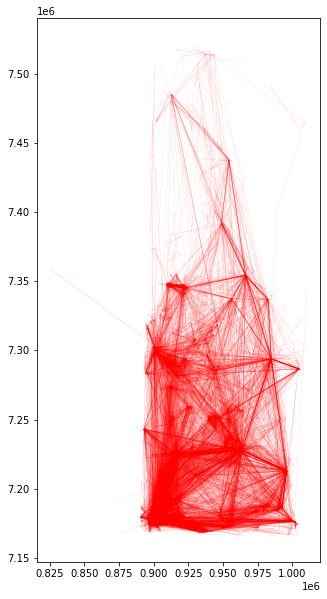

In [131]:
ax = movements.plot(color='red', figsize=(10, 10), alpha=0.5, linewidth=0.1, markersize=0.01)
plt.savefig('movements.png')
plt.show()

calculate travel lengths

In [128]:
# adding distance column
movements['distance'] = ''

# computing line lengths
for i, row in movements.iterrows():
    movements['distance'][i] = row['geometry'].length
movements.head()


C:\Users\Dell\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,userid,geometry,distance
0,16301,"LINESTRING (939011.113 7254636.121, 942231.630...",195251
1,26589,POINT (900800.126 7174374.539),0
2,29322,POINT (975417.175 7171978.245),0
3,42181,POINT (911006.669 7194909.337),0
4,45136,"LINESTRING (905394.500 7193375.148, 905394.500...",0


In [129]:
# save to .shp
# i can't create shapefile with both LineString and Points so i removed the Points objects
Some_movements = movements[movements['distance']>0]
Some_movements.head()

,userid,geometry,distance
0,16301,"LINESTRING (939011.113 7254636.121, 942231.630...",195251
6,50136,"LINESTRING (963788.403 7228015.063, 944551.607...",254703
12,88775,"LINESTRING (902800.817 7192546.975, 902800.839...",0.0802447
13,88918,"LINESTRING (959332.961 7219877.715, 963788.403...",9277.25
14,90156,"LINESTRING (944910.691 7243347.088, 944906.140...",33.231


In [130]:
Some_movements.to_file("Some_movements.shp",encoding='utf-8')

plot on map of South Africa

<function matplotlib.pyplot.show(*args, **kw)>

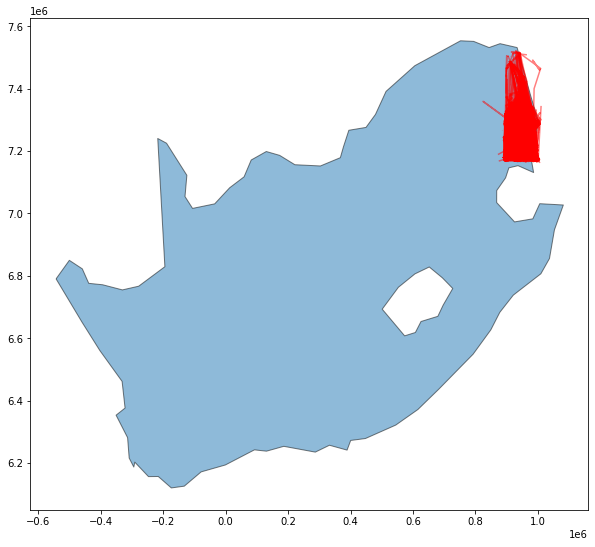

In [133]:
ax = world[world.name == 'South Africa'].plot(figsize=(10, 10), alpha=0.5, edgecolor='k')

movements.plot(ax=ax,color='red',alpha=0.5, markersize=0.01)
plt.show

shortest, average and longest distance travelled

In [132]:
print('shortest distance travelled is: {} [m]'.format(movements['distance'].replace(0, np.NaN).min()))
print('average distance travelled is: {} [m]'.format(movements['distance'].mean()))
print('longest distance travelled is: {} [m]'.format(movements['distance'].max()))

shortest distance travelled is: 0.00010161846437100987 [m]
average distance travelled is: 41601.72050073823 [m]
longest distance travelled is: 4535318.989620863 [m]


### section C

reading the activity locations

In [64]:

file_path = r'data\activity_locations.txt'
activity_locations = pd.read_csv(file_path, sep=';')
activity_locations.head()


,id,addr
0,0,"Arlozorov 64, Haifa, Israel"
1,1,"Hanadiv 7, Haifa, Israel"


finding cooardinates using geocode

In [52]:
# Geocode addresses with Nominatim backend
# geolocator = Nominatim(user_agent="users address")
geolocator = Nominatim(user_agent="users address")
geo_code = RateLimiter(geolocator.geocode, min_delay_seconds=1, max_retries=5, error_wait_seconds=5,return_value_on_exception=None)

geo = geocode(activity_locations['addr'])
# print(geo.crs)
geo.crs = {'init': 'epsg:4326'}
activity_locations = gpd.GeoDataFrame(geo, crs=from_epsg(4326))

activity_locations.head(2)

GeocoderQuotaExceeded: OVER_QUERY_LIMIT

In [65]:
# for when  geocode doesn't work
activity_locations = gpd.GeoDataFrame(activity_locations, crs=from_epsg(2039))
geometry = [Point(199981.462,745771.274), Point(198947.765,744109.790)]
activity_locations['geometry'] = geometry

activity_locations.head(2)

,id,addr,geometry
0,0,"Arlozorov 64, Haifa, Israel",POINT (199981.462 745771.274)
1,1,"Hanadiv 7, Haifa, Israel",POINT (198947.765 744109.790)


reading bus stops shapefile

In [66]:
bus_stops_file_path = r"data\Bus_Stops.shp"
bus_stops = gpd.read_file(bus_stops_file_path, encoding='utf-8')
bus_stops.head()

# projecting to israel TM grid
activity_locations = activity_locations.to_crs(epsg=2039)
bus_stops = bus_stops.to_crs(epsg=2039)

bus_stops.head()


,osm_id,timestamp,name,type,geometry
0,93820428,2015-02-18T10:38:37Z,מסעף גבת,bus_stop,POINT (220025.074 731512.908)
1,269680720,2010-12-22T12:05:35Z,None,bus_stop,POINT (188262.500 689349.896)
2,269680722,2009-03-23T19:26:30Z,None,bus_stop,POINT (188471.201 690776.030)
3,269724273,2008-10-19T19:03:58Z,None,bus_stop,POINT (188299.026 689942.007)
4,269724274,2008-10-19T19:03:58Z,None,bus_stop,POINT (188359.745 690351.544)


bus stops and activity location map

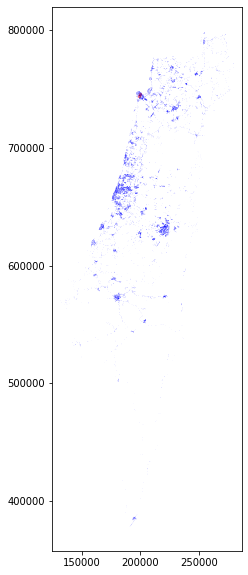

In [67]:
ax = activity_locations.plot(color='red', figsize=(10, 10), alpha=0.5, linewidth=0.1, markersize=10)
bus_stops.plot(ax=ax,color='blue', figsize=(10, 10), alpha=0.5, linewidth=0.1, markersize=0.01)
plt.show()

find nearest bus stops

In [68]:
# computing the distance to each bus stop
distances_1 =  bus_stops.apply(lambda row: activity_locations['geometry'][0].distance(row['geometry']), axis=1)
distances_2 =  bus_stops.apply(lambda row: activity_locations['geometry'][1].distance(row['geometry']), axis=1)

# sorting the distances so we can get the 5 closest bus stops
distances_1 = distances_1.sort_values(ascending=True)
distances_2 = distances_2.sort_values(ascending=True)
print(distances_1[0:5])
print(distances_2[0:5])

6479     119.423771
12706    165.732193
4271     195.692178
4270     206.269805
7017     214.073076
dtype: float64
31046     75.233427
31042    104.671848
359      125.635107
31047    143.497912
31041    176.591278
dtype: float64


adding the locations names of the bus stops

In [69]:
address1 = []
address2 = []
for addr1, addr2 in zip(bus_stops.iloc[distances_1.index[:5]].values[:, 2], bus_stops.iloc[distances_2.index[:5]].values[:, 2]):
    address1.append(addr1)
    address2.append(addr2)

addr = {'home': address1, 'work': address2}

print('the location names of the 5 closest bus stops are : ')

the location names of the 5 closest bus stops are : 
              home                 work
0  בלפור/ארלוזורוב  שד. מוריה/שד. הנדיב
1         הס/עצמון      שד. מוריה/נחשון
2   ארלוזורוב/יוסף              ככר ספר
3   ארלוזורוב/יוסף  שד. מוריה/שד. הנדיב
4  בר גיורא/הקנאים       שד. מוריה/יותם


In [134]:
pd.DataFrame(addr)

,home,work
0,בלפור/ארלוזורוב,שד. מוריה/שד. הנדיב
1,הס/עצמון,שד. מוריה/נחשון
2,ארלוזורוב/יוסף,ככר ספר
3,ארלוזורוב/יוסף,שד. מוריה/שד. הנדיב
4,בר גיורא/הקנאים,שד. מוריה/יותם


average distance and closest bus station

In [72]:
print('average distance to my home is: {} [m]'.format(np.average(distances_1)))
print('average distance to my work is: {} [m]'.format(np.average(distances_2)))
print('closest bus station to my home is',bus_stops.iloc[distances_1.index[0]]['name'])
print()
print('the distance is: {} [m]'.format(distances_1.values[0]))
print('closest bus station to my work is:',bus_stops.iloc[distances_2.index[0]]['name'])
print('the distance is: {} [m]'.format(distances_2.values[0]))

average distance to my home is: 83146.0063103271 [m]
average distance to my work is: 82168.33468612972 [m]
closest bus station to my home is בלפור/ארלוזורוב

the distance is: 119.42377108361391 [m]
closest bus station to my work is: שד. מוריה/שד. הנדיב
the distance is: 75.23342687202678 [m]


In [93]:
# fliping the coordinates
geometry =[]
for i,row in bus_stops.iterrows():
    geometry.append(Point(row['geometry'].y,row['geometry'].x))
bus_stops['geometry'] = geometry
bus_stops.head()
geometry =[]
for i,row in activity_locations.iterrows():
    geometry.append(Point(row['geometry'].y,row['geometry'].x))
activity_locations['geometry'] = geometry
bus_stops.head()

,osm_id,timestamp,name,type,geometry
0,93820428,2015-02-18T10:38:37Z,מסעף גבת,bus_stop,POINT (220025.074 731512.908)
1,269680720,2010-12-22T12:05:35Z,None,bus_stop,POINT (188262.500 689349.896)
2,269680722,2009-03-23T19:26:30Z,None,bus_stop,POINT (188471.201 690776.030)
3,269724273,2008-10-19T19:03:58Z,None,bus_stop,POINT (188299.026 689942.007)
4,269724274,2008-10-19T19:03:58Z,None,bus_stop,POINT (188359.745 690351.544)


Join the information from the closest bus stops to the address

In [94]:
# join closest bus stops to addresses
# activity_locations['closest bus stop location'] = [bus_stops.iloc[distances_1.index[0]]['geometry'], bus_stops.iloc[distances_2.index[0]]['geometry']]
# activity_locations.head()

My_address_bus_stops = activity_locations.join(bus_stops.iloc[:2], lsuffix='_caller', rsuffix='_other')
My_address_bus_stops.head()

My_address_bus_stops.rename(columns = {'geometry_caller': 'geometry', 'geometry_other': 'closest bus stop location'}, inplace = True)
My_address_bus_stops = My_address_bus_stops.iloc[:,:-1]
My_address_bus_stops.head()

,id,addr,geometry,osm_id,timestamp,name,type
0,0,"Arlozorov 64, Haifa, Israel",POINT (199981.462 745771.274),93820428,2015-02-18T10:38:37Z,מסעף גבת,bus_stop
1,1,"Hanadiv 7, Haifa, Israel",POINT (198947.765 744109.790),269680720,2010-12-22T12:05:35Z,None,bus_stop


In [95]:
My_address_bus_stops.to_file('My_address_bus_stops.shp',encoding='utf-8')
